In [4]:
from IPython.display import display, Audio #dlya displaya audio

In [3]:
import soundfile as sf #dlya chteniya zapici b write zapisy
data, sample_rate=sf.read('audio_2024-11-21_23-57-23.ogg')

print(data.shape, sample_rate)

(1285440,) 48000


In [7]:
display(Audio('audio/output_modified1-12-0-23.wav'))

In [7]:
sf.write('model/audio.flac', data,sample_rate)

In [8]:
import wave #для волн djky

In [9]:
import pyaudio #для записи с микро

In [10]:
CHUNK =1024
FORMAT= pyaudio.paInt16
CHANNELS = 1
RATE =44100

p=pyaudio.PyAudio()

stream=p.open(format=FORMAT,channels=CHANNELS,rate=RATE, input=True, frames_per_buffer=CHUNK)
print("recordin...")
frames=[]
seconds = 3 
for i in range(0, int(RATE/CHUNK*seconds)):
    data=stream.read(CHUNK)
    frames.append(data)

print('stopped recording')

stream.stop_stream()
stream.close()
p.terminate()

wf= wave.open('output.wav','wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

recordin...
stopped recording


In [12]:
#SoundDevice: bindings for the portAudio and a few convenience functions to record
display(Audio('output.wav'))

In [1]:
import sounddevice as sd 

fs=44100
duration=5.0 # seconds

myrecording =sd.rec(int(duration*fs),samplerate=fs , channels=1)

sd.wait()
sd.play(myrecording,fs)

In [2]:
sd.play('output.wav',fs)

TypeError: Unsupported data type: 'str320'

In [ ]:
#pip install pydub
#from pydub import AudioSegment 
#audio = AudioSegment.from_wav('path_to_audio.wav')
#u can adjust audio ezly and mp3 too

In [15]:
#librosa
#TorchAudio 

In [1]:
import torch
import torchaudio
print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.5.1+cpu
2.5.1+cpu
cpu


In [15]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = "audio_2024-11-21_23-57-23.ogg" #download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

In [16]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_LARGE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [17]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [18]:
IPython.display.Audio(SPEECH_FILE)

In [19]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [20]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

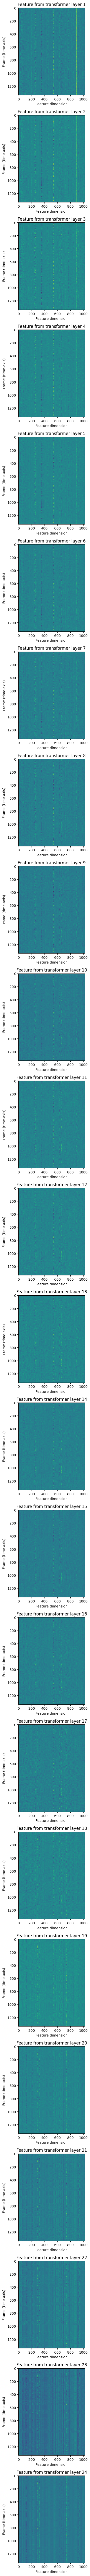

In [21]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [22]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


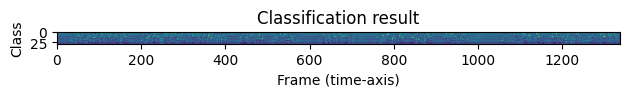

In [23]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [24]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [25]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [26]:
print(transcript)

IT'S|GIRTA|SNAW|MAN|FOR|FOO|CHOSEN|PEOPLE|IT'S|MEN|FOR|USE|FOR|PUSEING|THET|PURSUES|THEIR|DREAMS|O|WE|GAN|AND|MAKE|THER|CHOICE|AN'S|A|WAY|COP|JUST|MENTALED|TO|RELLY|ASPIRATION|COMES|FROM|AMAZING|PEOPLE|WHO|DO|LITTLE|SNAZI|BUT|ITS|ORDINARY|PEOPLE|WILL|DO|LITTLE|THINGS|IT|AS|OF|PEOPLE|AREN'T|DREIN|


In [4]:
import whisper
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Загружаем модель
detect_language={
    "en": 0.98, 
    "ru": 0.02
}
model = whisper.load_model("base")

# Загружаем аудио
audio_path = "output30-11-1-26.wav"
audio = whisper.load_audio(audio_path)
audio = whisper.pad_or_trim(audio)

# Преобразуем аудио в мел-спектрограмму
mel = whisper.log_mel_spectrogram(audio).to(model.device)
# Определяем язык
detected_language = max(model.detect_language(mel)["language"], key=model.detect_language(mel)["language"].get)
print(f"Определённый язык: {detected_language}")
options = whisper.DecodingOptions(language=detected_language, task="transcribe")

# Расшифровываем аудио
result = whisper.decode(model, mel, options)
print("Результат:", result.text)
# result = model.transcribe("audio_2024-11-21_23-57-23.ogg")

TypeError: tuple indices must be integers or slices, not str

In [18]:
import os
print(os.path.exists("output.wav"))
audio_path = os.path.join(os.path.dirname("D:\ProjectML\ml-final-project\output.wav"), "output.wav")
model = whisper.load_model("base").to(device)
result = model.transcribe(
        audio_path, temperature=0.0, word_timestamps=True
    )

<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:3: SyntaxWarning: invalid escape sequence '\P'
C:\Users\NoXS1d\AppData\Local\Temp\ipykernel_9584\621230551.py:3: SyntaxWarning: invalid escape sequence '\P'
  audio_path = os.path.join(os.path.dirname("D:\ProjectML\ml-final-project\output.wav"), "output.wav")


True


C:\Users\NoXS1d\AppData\Local\Temp\ipykernel_9584\621230551.py:3: SyntaxWarning: invalid escape sequence '\P'
  audio_path = os.path.join(os.path.dirname("D:\ProjectML\ml-final-project\output.wav"), "output.wav")


FileNotFoundError: [WinError 2] Не удается найти указанный файл

In [1]:
import os
import whisper
import ffmpeg
# Путь к файлу
audio_path = r"D:\ProjectML\ml-final-project\output.wav"

# Проверяем наличие файла
if not os.path.exists(audio_path):
    raise FileNotFoundError(f"File not found: {audio_path}")

# Загружаем модель Whisper
model = whisper.load_model("base")

# Выполняем расшифровку
result = model.transcribe(audio_path, temperature=0.0, word_timestamps=True)

# Выводим результатz
print("Transcript:", result["text"])


C:\Users\NoXS1d\AppData\Local\Programs\Python\Python312\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, 

Transcript:  Привет мир!


In [6]:
import whisper

# Загружаем модель
model = whisper.load_model("base")

# Загружаем аудио
audio = whisper.load_audio("output30-11-1-26.wav")
audio = whisper.pad_or_trim(audio)

# Преобразуем аудио в мел-спектрограмму
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# Определяем язык
lang_result = model.detect_language(mel)
probabilities = lang_result[0]  # Первый элемент — вероятности языков
detected_language = lang_result[1]  # Второй элемент — язык с наибольшей вероятностью

print(f"Определённый язык: {detected_language} (вероятность: {probabilities[detected_language]:.2f})")

# Настраиваем параметры декодирования
options = whisper.DecodingOptions(language=detected_language, task="transcribe")

# Декодируем аудио
result = whisper.decode(model, mel, options)

# Выводим результат
print("Транскрипт:", result.text)


IndexError: too many indices for tensor of dimension 0

In [8]:
import whisper

# Загрузка модели
model = whisper.load_model("small")

# Загрузка и подготовка аудио
audio = whisper.load_audio("output30-11-1-26.wav")
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# Определение языка
detected_lang = model.detect_language(mel)
print("Detected language:", detected_lang[1]) 

AssertionError: incorrect audio shape

In [9]:
result = model.transcribe("output30-11-1-26.wav")

In [13]:
print("Транскрипт:", result['text'])

Транскрипт:  Предположительно, я должен записывать это рекординг в 30 секунд, так что я буду повстать все, что угодно пока это классовое сообщение записывается. Так что, думаю, осталось где-то 10 секунд, и оно скоро закончится. Так, после этого мы попробуем интервести это в текст.


In [2]:
import whisper

model = whisper.load_model("base")

# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("output30-11-1-26.wav")
audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio, n_mels=model.dims.n_mels).to(model.device)

# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# decode the audio
options = whisper.DecodingOptions()
result = whisper.decode(model, mel, options)

# print the recognized text
print(result)

C:\Users\NoXS1d\AppData\Local\Programs\Python\Python312\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, 

Detected language: ru
DecodingResult(audio_features=tensor([[-1.2754,  0.2712, -1.0684,  ..., -0.9453, -0.1409,  0.7974],
        [-0.7197,  0.1951,  0.2505,  ..., -0.3770,  0.0560,  0.0049],
        [-0.3474,  0.2966, -0.0566,  ..., -0.3079,  0.3147,  0.0748],
        ...,
        [-0.3452, -0.4683,  0.7271,  ...,  0.7378,  0.8140,  0.5845],
        [-0.1846, -0.4768,  0.1997,  ...,  0.6353,  0.8872,  0.0446],
        [-0.1365, -0.0619,  0.4524,  ..., -0.0630,  0.4065, -0.7031]],
       device='cuda:0', dtype=torch.float16), language='ru', language_probs=None, tokens=[50364, 46825, 37251, 15884, 11, 2552, 25718, 36426, 2209, 2691, 25492, 2765, 856, 33177, 1722, 13, 3446, 50653, 50653, 7887, 2552, 21407, 3348, 386, 3619, 403, 2209, 4640, 2143, 20392, 44356, 17770, 2691, 10655, 13247, 698, 4610, 1006, 1725, 36426, 4655, 6970, 51016, 51016, 2936, 2143, 13082, 1218, 12574, 13340, 11418, 12, 860, 981, 435, 3167, 1148, 4401, 11, 2552, 6448, 44971, 39641, 14260, 51466, 51466], text='Предполо